In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

# File paths
dga_malware_file = "/home/ubuntu/DoH_DGA_training/datasets/DGA/all_pcaps_allN.csv"

dga_synthetic_file1 = "/home/ubuntu/DoH_DGA_training/datasets/DGA_PCAPS1_ENC/all_pcaps_allN.csv"
dga_synthetic_file2 = "/home/ubuntu/DoH_DGA_training/datasets/DGA_PCAPS2_ENC/all_pcaps_allN.csv"

doh_tunnel_file = "/home/ubuntu/DoH_DGA_training/datasets/DoH_HKD/DoH-Pcaps/all_pcaps_allN.csv"

# Load datasets
df_dga_malware = pd.read_csv(dga_malware_file)

df_dga_synthetic1 = pd.read_csv(dga_synthetic_file1)
df_dga_synthetic2 = pd.read_csv(dga_synthetic_file2)

df_doh_tunnel = pd.read_csv(doh_tunnel_file)

# Assign labels
df_dga_malware["label"] = "DGA_MALWARE"

df_dga_synthetic1["label"] = "DGA_Synthetic"
df_dga_synthetic2["label"] = "DGA_Synthetic"
df_dga_synthetic = pd.concat([df_dga_synthetic1, df_dga_synthetic2], ignore_index=True)

df_doh_tunnel["label"] = "DoH_Tunnel"

print("DGA_MALWARE shape:", df_dga_malware.shape)
print("DGA_Synthetic shape:", df_dga_synthetic.shape)
print("DoH_Tunnel shape:", df_doh_tunnel.shape)

# Combine all into one DataFrame
df_all = pd.concat([df_dga_malware, df_dga_synthetic, df_doh_tunnel], ignore_index=True)
df_all = pd.concat([df_dga_malware, df_doh_tunnel], ignore_index=True)

print("\nFinal dataset shape:", df_all.shape)
print("Labels distribution:\n", df_all["label"].value_counts())
print("Columns:\n", list(df_all.columns))


DGA_MALWARE shape: (9012, 25)
DGA_Synthetic shape: (6460, 25)
DoH_Tunnel shape: (6008, 26)

Final dataset shape: (15020, 26)
Labels distribution:
 label
DGA_MALWARE    9012
DoH_Tunnel     6008
Name: count, dtype: int64
Columns:
 ['session_id', 'client_ip', 'server_ip', 'client_port', 'server_port', 'protocol', 'N', 'n_client', 'client_bytes', 'client_pkt_min', 'client_pkt_mean', 'client_pkt_max', 'client_iat_min', 'client_iat_mean', 'client_iat_max', 'n_server', 'server_bytes', 'server_pkt_min', 'server_pkt_mean', 'server_pkt_max', 'server_iat_min', 'server_iat_mean', 'server_iat_max', 'bytes_ratio', 'label', 'pcap_file']


In [2]:
N_value = 8   # <-- change this to 8, 16, 32, 64 as needed
df_subset = df_all[df_all["N"] == N_value].copy()

print(f"\nTraining on N={N_value}, dataset size={df_subset.shape[0]}")

# Separate features and target
y = df_subset["label"]
X = df_subset.drop(columns=[
    "label", 'session_id', 'client_ip', 'server_ip', 
    'client_port', 'server_port', 'protocol', 'N',
    "flow_id", "src_ip", "dst_ip", 
    "src_port", "dst_port", "protocol", 'pcap_file'
], errors="ignore")

# Keep only numeric features
X = X.select_dtypes(include=["int64", "float64"])

print("Remaining feature columns:\n", list(X.columns))
print("Target classes:", y.unique())


Training on N=8, dataset size=3755
Remaining feature columns:
 ['n_client', 'client_bytes', 'client_pkt_min', 'client_pkt_mean', 'client_pkt_max', 'client_iat_min', 'client_iat_mean', 'client_iat_max', 'n_server', 'server_bytes', 'server_pkt_min', 'server_pkt_mean', 'server_pkt_max', 'server_iat_min', 'server_iat_mean', 'server_iat_max', 'bytes_ratio']
Target classes: ['DGA_MALWARE' 'DoH_Tunnel']


In [3]:
# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.3, random_state=42, stratify=y_enc
)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Train MLP
mlp = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=200, random_state=42)
mlp.fit(X_train, y_train)

# Evaluate
y_pred = mlp.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Classification Report:
              precision    recall  f1-score   support

 DGA_MALWARE       1.00      1.00      1.00       676
  DoH_Tunnel       1.00      1.00      1.00       451

    accuracy                           1.00      1127
   macro avg       1.00      1.00      1.00      1127
weighted avg       1.00      1.00      1.00      1127



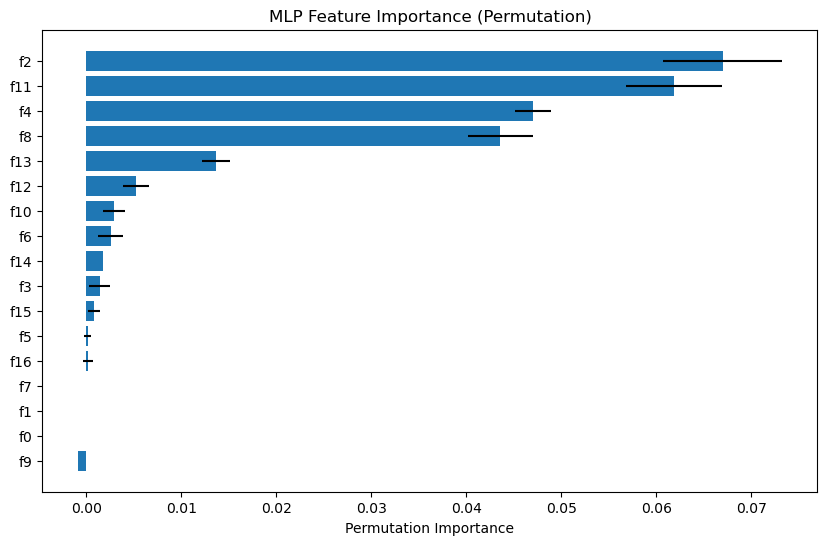

In [8]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# --- Create generic feature names ---
feature_names = [f"f{i}" for i in range(X_train.shape[1])]

# Compute permutation importance on test set
result = permutation_importance(
    mlp, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Sort by importance
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(
    range(len(sorted_idx)), 
    result.importances_mean[sorted_idx], 
    xerr=result.importances_std[sorted_idx]
)
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("MLP Feature Importance (Permutation)")
plt.show()


In [15]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Use very small samples for KernelExplainer
sample_size = 50  # Small sample size for speed
background_size = 20  # Very small background set

np.random.seed(42)
background_indices = np.random.choice(len(X_train), size=background_size, replace=False)
test_indices = np.random.choice(len(X_test), size=sample_size, replace=False)

X_train_background = X_train[background_indices]
X_test_sample = X_test[test_indices]

print("Using KernelExplainer (this may take a few minutes)...")

# Create explainer - use the probability output
explainer = shap.KernelExplainer(mlp.predict_proba, X_train_background)

# Calculate SHAP values for class 0
target_class = 0  # Change to 1 for class 1

shap_values = explainer.shap_values(X_test_sample)

print(f"SHAP calculation completed!")

# Plot the results
feature_names = X.columns if hasattr(X, 'columns') else [f'Feature_{i}' for i in range(X_train.shape[1])]

# Summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values[target_class], X_test_sample, 
                 feature_names=feature_names,
                 show=False)
plt.title(f"SHAP Summary - Class {target_class} ({le.classes_[target_class]})")
plt.tight_layout()
plt.show()

Using KernelExplainer (this may take a few minutes)...


100%|██████████| 50/50 [00:02<00:00, 22.94it/s]

SHAP calculation completed!



/tmp/ipykernel_66079/3480422207.py:33: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[target_class], X_test_sample,


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 1000x600 with 0 Axes>